# MOVIELENS RECOMMENDER SYSTEM
Our goal is to build a system that recommends the top 5 movies to a specific user based on their historical ratings. The core idea is to leverage the collective wisdom of all users in the MovieLens dataset to predict what an individual will enjoy. This problem is tackled by answering four fundaments questions:
    
    1. How do we find users with the same movie taste? (Collaborative Filtering (User-User))
    Method: We calculate a "taste similarity" score between users. The most common way is using Cosine Similarity or Pearson Correlation or average rating.
    How it works: Each user is represented as a vector of their movies ratings. We then compare the rating vector of our target user to every other user's vector.
    Anology: It's like finding your "movie doppelganger". If you and another user have both rated 20 movies similarly (e.g you both loved the Godfather and hated a particular romantic comedy), the system identifies you as having similar taste. This user's other high-rated movies become strong candidates for your recommendations.
    
    2. How do we find movies that are similar to the ones the user already likes? (Content-Based/item-item Collaborative Filtering)
    Content-Based: We use metadata about the movies like the genres. If a user highly rates Inception, we recommend other movies tagged as "sci-fiction", "thriller".
    Item-Item Collaborative Filtering: It finds similarity based on user behavior. "People who liked movie X also liked movie Y." We compute similarity between movies based on how users have rated them collectively. For example, if users who rated The Shawshank Redemption highly also consistently rated The Godfather highly, these two movies are deemed similar.
    
    3. How can we predict a user's rating for an unrated movie?
    This is the core prediction engine, by combining the concepts above.
    User-User Prediction: To predict your rating for Movie M, the system looks at the users most similar to you (your "neighbors") who have already rated Movie M. Your predicted rating is a weighted average of their ratings for that movie.
    Item-Item Prediction: To predict your rating for Movie M, the system looks at the movies most similar to Movie M that you have already rated. Your predicted rating is calculated based on your ratings for these similar movies.
    
    4. How do we generate the final Top 5 recommendations?
    Once we can predict ratings, then we:
    Generate Predictions: For our target user, we run the predictions algorithm for all movies the user has not yet seen.
    Rank the list: We sort this list of unseen movies by their predicted rating in descending order.
    Select the top N: The top 5 movies from this sorted list are selected as the final recommendations.


## DATA LOADING AND EXPLORATORY DATA ANALYSIS (EDA)

In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds


import warnings
warnings.filterwarnings('ignore')

# Set styling for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

%matplotlib inline

In [2]:
#load data
df_movies = pd.read_csv('DATA/movies.csv')
df_ratings = pd.read_csv('DATA/ratings.csv')
df_tags = pd.read_csv('DATA/tags.csv')
df_links = pd.read_csv('DATA/links.csv')

In [3]:
# Display the first few rows of each to get a initial feel
print("MOVIES DATA:")
print(df_movies.head())
print("\n" + "="*50 + "\n")

print("RATINGS DATA:")
print(df_ratings.head())
print("\n" + "="*50 + "\n")

# print("TAGS DATA:")
# print(df_tags.head())
# print("\n" + "="*50 + "\n")

# print("LINKS DATA:")
# print(df_links.head())

MOVIES DATA:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


RATINGS DATA:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931




In [4]:
def basic_info(df, name):
    """Prints basic information about a DataFrame."""
    print(f"--- {name} INFO ---")
    print(f"Shape: {df.shape}")  # (rows, columns)
    print("\nData Types:")
    print(df.dtypes)
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\n" + "-"*40)

# Apply to all DataFrames
basic_info(df_movies, "MOVIES")
basic_info(df_ratings, "RATINGS")
basic_info(df_tags, "TAGS")
basic_info(df_links, "LINKS")

--- MOVIES INFO ---
Shape: (9742, 3)

Data Types:
movieId     int64
title      object
genres     object
dtype: object

Missing Values:
movieId    0
title      0
genres     0
dtype: int64

----------------------------------------
--- RATINGS INFO ---
Shape: (100836, 4)

Data Types:
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

Missing Values:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

----------------------------------------
--- TAGS INFO ---
Shape: (3683, 4)

Data Types:
userId        int64
movieId       int64
tag          object
timestamp     int64
dtype: object

Missing Values:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

----------------------------------------
--- LINKS INFO ---
Shape: (9742, 3)

Data Types:
movieId      int64
imdbId       int64
tmdbId     float64
dtype: object

Missing Values:
movieId    0
imdbId     0
tmdbId     8
dtype: int64

------------------------

# Movies Dataset Overview

## Movies Data
- **Entries**: 9,742 movies
- **Features**:
  - `movieId` (int64): Unique movie identifier
  - `title` (object): Movie title with release year
  - `genres` (object): Pipe-separated list of genres
- **Data Quality**: No missing values in any column

## Ratings Data
- **Entries**: 100,836 ratings
- **Features**:
  - `userId` (int64): Unique user identifier
  - `movieId` (int64): Corresponding movie identifier
  - `rating` (float64): User rating (typically 0.5-5.0)
  - `timestamp` (int64): Unix timestamp of rating
- **Data Quality**: No missing values in any column

## Tags Data
- **Shape**: 3,683 rows × 4 columns
- **Columns**:
  - `userId`: int64 (user identifier)
  - `movied`: int64 (movie identifier)
  - `tag`: object (string tag applied by user)
  - `timestamp`: int64 (Unix timestamp)
- **Data Quality**: None in any column

## Links Data
- **Shape**: 9,742 rows × 3 columns
- **Columns**:
  - `movied`: int64 (movie identifier)
  - `imdbId`: int64 (IMDB identifier)
  - `tmdbId`: float64 (TMDb identifier, stored as float due to missing values)
- **Data Quality**: 
  - 8 missing values in `tmdbId` column
  - None in `movierd` or `imdbId`

## Key Points
- Clean dataset with no missing values other than `tmdbId` which has 8 missing entries out of 9,742
- Structured for movie recommendation analysis
- Contains user-movie interactions with ratings
- Movies dataset includes genre information for content-based filtering

In [5]:
# Display settings for better visualization output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set a professional color palette and style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
professional_palette = ["#2E86AB", "#A23B72", "#F18F01", "#C73E1D", "#3B1F2B", "#6A8EAE"]
sns.set_palette(professional_palette)

# Custom style parameters
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 14

--- MOVIES DEEP DIVE ---
Total number of movies: 9742

Sample of movie titles:
['Cujo (1983)', 'Better Living Through Circuitry (1999)', 'Loved Ones, The (2009)', 'Summer Wars (Samâ wôzu) (2009)', 'Man on Wire (2008)', 'Dr. Phibes Rises Again (1972)', 'Truth About Cats & Dogs, The (1996)', 'Jungle Book, The (1967)', 'Marnie (1964)', 'Game 6 (2005)']

Year range: 1902 - 2018
Movies without year: 13

--- GENRE ANALYSIS ---
Total genre occurrences: 22084
Unique genres: ['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'War' 'Musical'
 'Documentary' 'IMAX' 'Western' 'Film-Noir' '(no genres listed)']


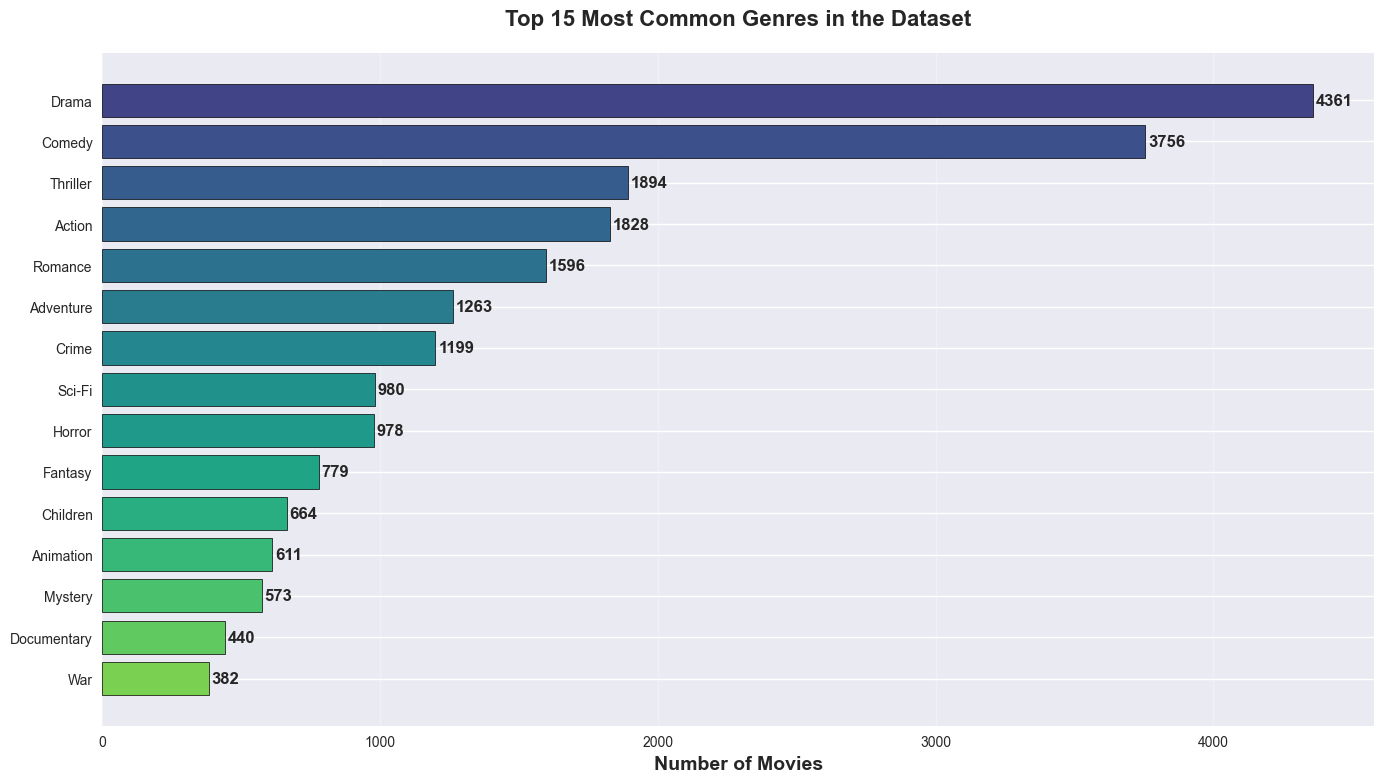

In [6]:
print("--- MOVIES DEEP DIVE ---")
print(f"Total number of movies: {df_movies['movieId'].nunique()}")
print("\nSample of movie titles:")
print(df_movies['title'].sample(10).tolist())

# Let's extract the year from the title and see the range
# Note: This is a common pattern in Movielens data: "Title (Year)"
df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)')
df_movies['year'] = pd.to_numeric(df_movies['year'], errors='coerce').astype('Int64')

print(f"\nYear range: {df_movies['year'].min()} - {df_movies['year'].max()}")
print(f"Movies without year: {df_movies['year'].isnull().sum()}")

# Analyze genres
print("\n--- GENRE ANALYSIS ---")
# Split genres which are pipe-separated
all_genres = df_movies['genres'].str.split('|', expand=True).stack()
print(f"Total genre occurrences: {len(all_genres)}")
print(f"Unique genres: {all_genres.unique()}")

# Top genres
plt.figure(figsize=(14, 8))
genre_counts = all_genres.value_counts().head(15)

# Create a gradient color palette based on count values
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(genre_counts)))
bars = plt.barh(range(len(genre_counts)), genre_counts.values, color=colors, edgecolor='black', linewidth=0.5)

plt.yticks(range(len(genre_counts)), genre_counts.index)
plt.xlabel('Number of Movies', fontweight='bold')
plt.title('Top 15 Most Common Genres in the Dataset', fontweight='bold', pad=20)

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 10, bar.get_y() + bar.get_height()/2, f'{int(width)}', 
             ha='left', va='center', fontweight='bold')

plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

--- RATINGS DEEP DIVE ---


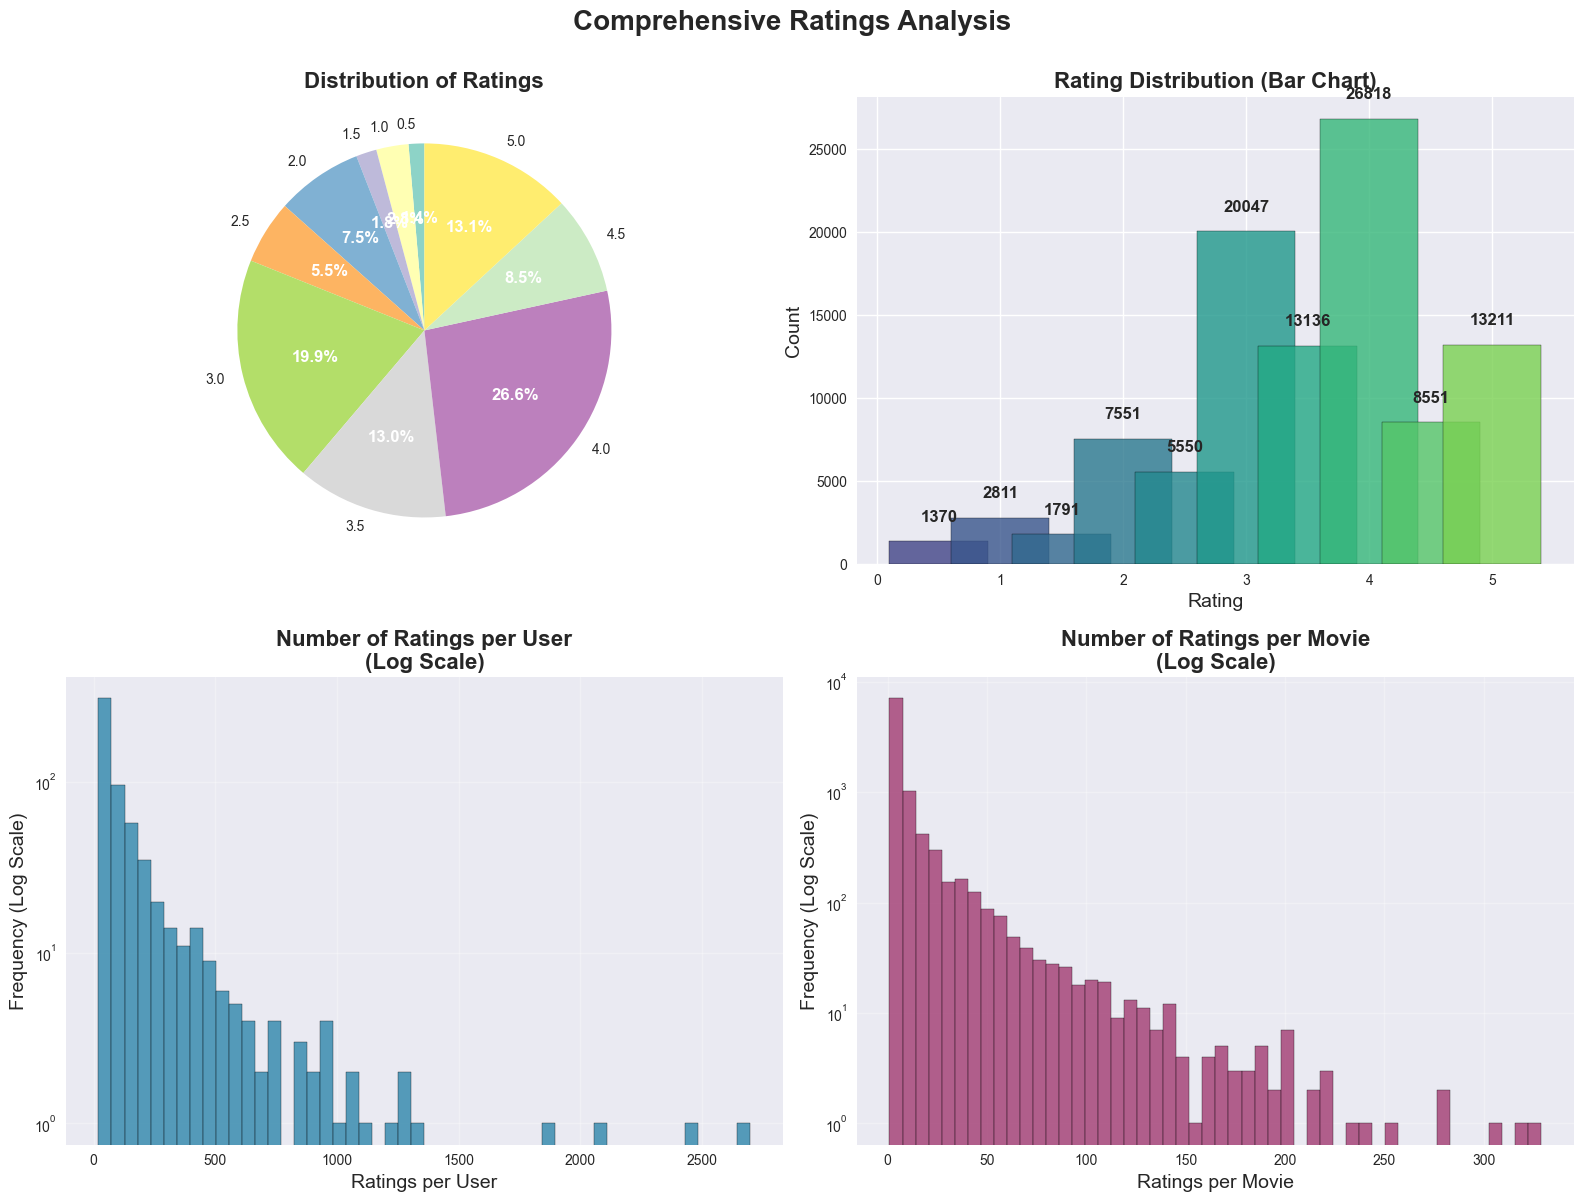

Rating period: 1996-03-29 18:36:55 to 2018-09-24 14:27:30


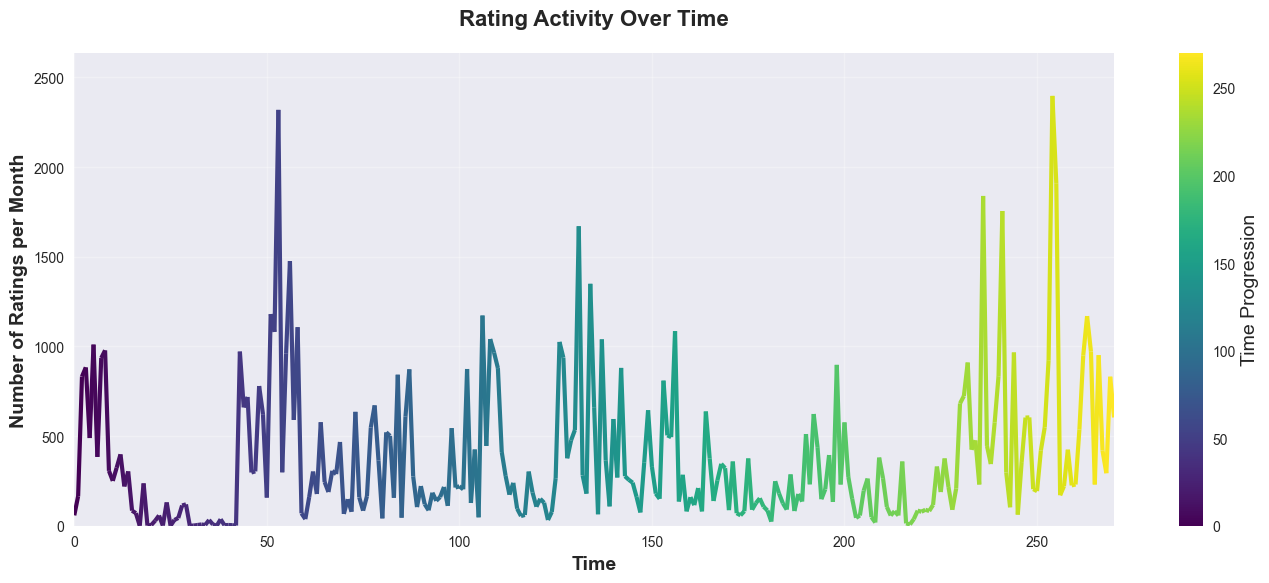

In [7]:
print("--- RATINGS DEEP DIVE ---")

# Create a comprehensive ratings overview plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comprehensive Ratings Analysis', fontsize=20, fontweight='bold', y=1.0)

# 1. Rating distribution (pie chart)
rating_counts = df_ratings['rating'].value_counts().sort_index()
colors_ratings = plt.cm.Set3(np.linspace(0, 1, len(rating_counts)))
wedges, texts, autotexts = axes[0,0].pie(rating_counts.values, labels=rating_counts.index, 
                                        colors=colors_ratings, autopct='%1.1f%%', startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
axes[0,0].set_title('Distribution of Ratings', fontweight='bold')

# 2. Rating distribution (bar chart)
colors_bars = plt.cm.viridis(np.linspace(0.2, 0.8, len(rating_counts)))
axes[0,1].bar(rating_counts.index, rating_counts.values, color=colors_bars, 
              edgecolor='black', alpha=0.8)
axes[0,1].set_xlabel('Rating')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Rating Distribution (Bar Chart)', fontweight='bold')
for i, v in enumerate(rating_counts.values):
    axes[0,1].text(rating_counts.index[i], v + 1000, str(v), 
                   ha='center', va='bottom', fontweight='bold')

# 3. Ratings per user (with log scale for better visualization)
user_rating_counts = df_ratings['userId'].value_counts()
axes[1,0].hist(user_rating_counts, bins=50, color='#2E86AB', edgecolor='black', alpha=0.8)
axes[1,0].set_yscale('log')
axes[1,0].set_xlabel('Ratings per User')
axes[1,0].set_ylabel('Frequency (Log Scale)')
axes[1,0].set_title('Number of Ratings per User\n(Log Scale)', fontweight='bold')
axes[1,0].grid(alpha=0.3)

# 4. Ratings per movie (with log scale)
movie_rating_counts = df_ratings['movieId'].value_counts()
axes[1,1].hist(movie_rating_counts, bins=50, color='#A23B72', edgecolor='black', alpha=0.8)
axes[1,1].set_yscale('log')
axes[1,1].set_xlabel('Ratings per Movie')
axes[1,1].set_ylabel('Frequency (Log Scale)')
axes[1,1].set_title('Number of Ratings per Movie\n(Log Scale)', fontweight='bold')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Temporal analysis with enhanced styling
df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')
print(f"Rating period: {df_ratings['timestamp'].min()} to {df_ratings['timestamp'].max()}")

plt.figure(figsize=(14, 6))
monthly_ratings = df_ratings.set_index('timestamp').resample('M').size()

# Create a gradient line plot
x = range(len(monthly_ratings))
y = monthly_ratings.values

# Create a gradient colored line
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

from matplotlib.collections import LineCollection
lc = LineCollection(segments, cmap='viridis', linewidth=3)
lc.set_array(np.array(x))

plt.gca().add_collection(lc)
plt.xlim(min(x), max(x))
plt.ylim(0, max(y) * 1.1)

plt.xlabel('Time', fontweight='bold')
plt.ylabel('Number of Ratings per Month', fontweight='bold')
plt.title('Rating Activity Over Time', fontweight='bold', pad=20)


# Add a colorbar
plt.colorbar(lc, label='Time Progression')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# Merge ratings with movie information
df_ratings_movies = pd.merge(df_ratings, df_movies, on='movieId')
print("Ratings merged with movie info:")
print(df_ratings_movies.head())

# Average rating per movie
movie_stats = df_ratings_movies.groupby('movieId').agg({
    'rating': ['count', 'mean'],
    'title': 'first'
}).round(2)
movie_stats.columns = ['rating_count', 'avg_rating', 'title']
movie_stats = movie_stats.reset_index()

print("\nMovies with highest number of ratings:")
print(movie_stats.nlargest(10, 'rating_count')[['title', 'rating_count', 'avg_rating']])

print("\nMovies with highest average rating (min 50 ratings):")
high_rated = movie_stats[movie_stats['rating_count'] >= 50]
print(high_rated.nlargest(10, 'avg_rating')[['title', 'rating_count', 'avg_rating']])

Ratings merged with movie info:
   userId  movieId  rating           timestamp                        title  \
0       1        1     4.0 2000-07-30 18:45:03             Toy Story (1995)   
1       1        3     4.0 2000-07-30 18:20:47      Grumpier Old Men (1995)   
2       1        6     4.0 2000-07-30 18:37:04                  Heat (1995)   
3       1       47     5.0 2000-07-30 19:03:35  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0 2000-07-30 18:48:51   Usual Suspects, The (1995)   

                                        genres  year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995  
1                               Comedy|Romance  1995  
2                        Action|Crime|Thriller  1995  
3                             Mystery|Thriller  1995  
4                       Crime|Mystery|Thriller  1995  

Movies with highest number of ratings:
                                          title  rating_count  avg_rating
314                         Forrest Gump (1994)  

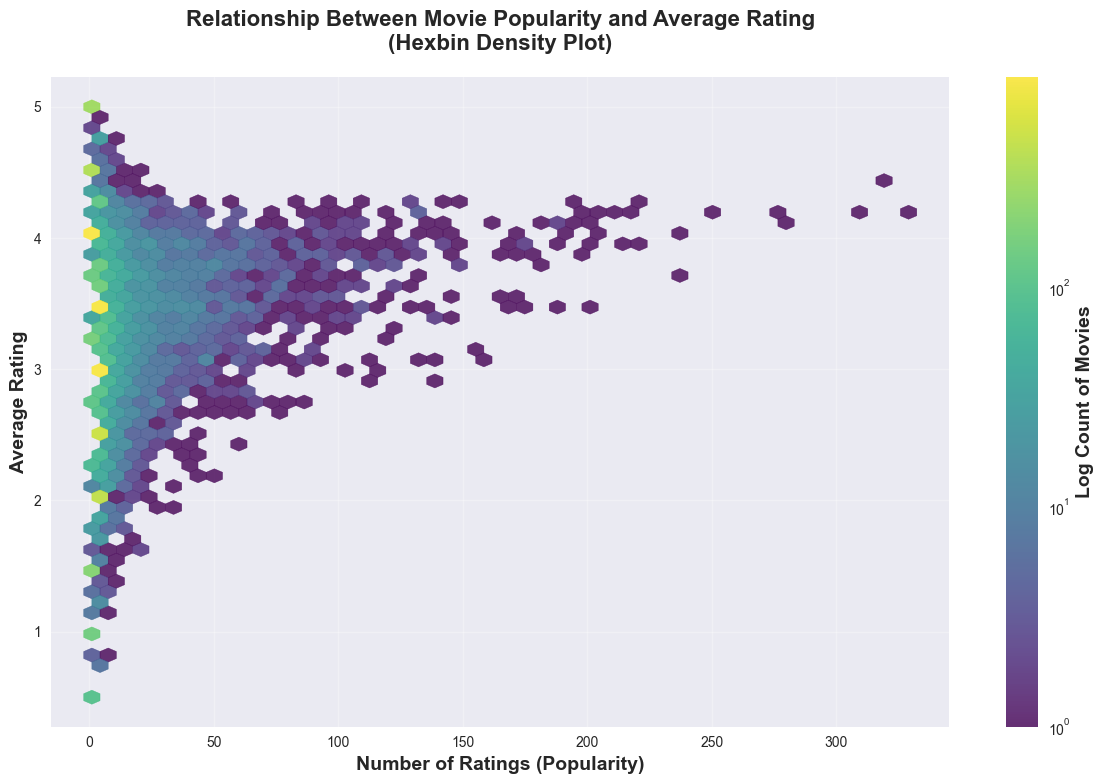

In [9]:
# Relationship between popularity and rating 
plt.figure(figsize=(12, 8))

# Create a hexbin plot for better density visualization
hb = plt.hexbin(movie_stats['rating_count'], movie_stats['avg_rating'], 
                gridsize=50, cmap='viridis', bins='log', alpha=0.8)

plt.xlabel('Number of Ratings (Popularity)', fontweight='bold')
plt.ylabel('Average Rating', fontweight='bold')
plt.title('Relationship Between Movie Popularity and Average Rating\n(Hexbin Density Plot)', 
          fontweight='bold', pad=20)

# Add colorbar
cb = plt.colorbar(hb, label='Log Count of Movies')
cb.set_label('Log Count of Movies', fontweight='bold')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Plot Interpretation: Popularity vs. Rating Relationship

**Chart Type**: Hexbin Density Plot  
**X‑axis**: Number of Ratings (Popularity) – higher values indicate more views/reviews  
**Y‑axis**: Average Rating – typical rating given by users (e.g., 1–5 scale)  

**Key Insight**:  
The hexbin shading shows concentration:  
- Most movies receive **few ratings** (clustered near the left side).  
- Average ratings are generally **between 3.0 and 4.0**, regardless of popularity.  
- Highly popular movies (right side) maintain similar average ratings—no strong correlation between popularity and higher ratings.  

**Takeaway**:  
Popularity (number of ratings) does not guarantee higher average scores; rating distribution remains consistent across view counts.

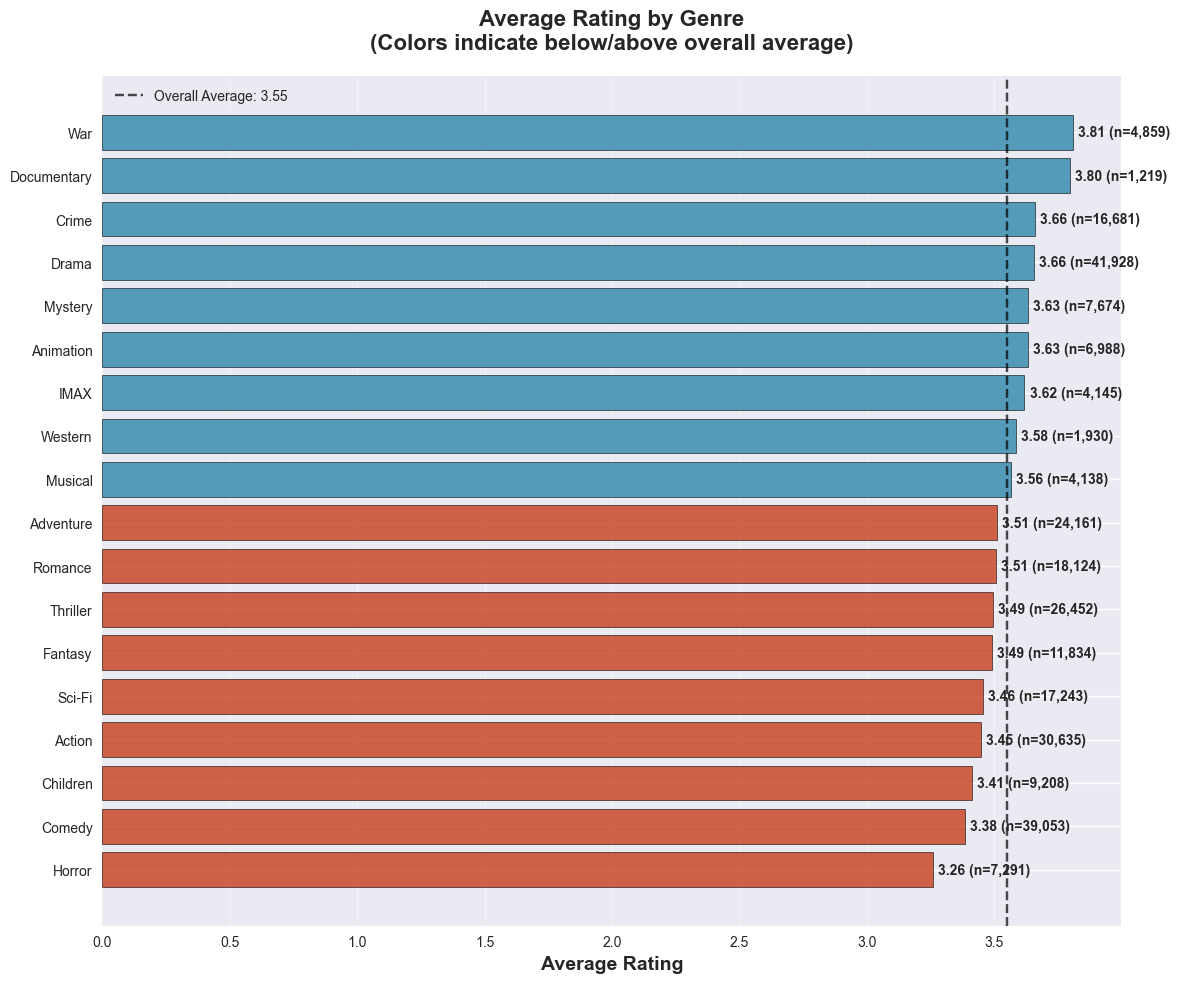

In [10]:
# Average rating by genre
genre_ratings = df_ratings_movies.copy()
# Expand genres so we can analyze them separately
genre_ratings['genres'] = genre_ratings['genres'].str.split('|')
genre_ratings = genre_ratings.explode('genres')

genre_avg = genre_ratings.groupby('genres')['rating'].agg(['mean', 'count']).round(3)
genre_avg = genre_avg[genre_avg['count'] > 1000]  # Filter for meaningful genres
genre_avg = genre_avg.sort_values('mean', ascending=False)

plt.figure(figsize=(12, 10))
genre_avg = genre_avg.sort_values('mean', ascending=True)  # Sort for horizontal bar chart

# Create a diverging color palette based on rating values
colors = ['#C73E1D' if x < genre_avg['mean'].mean() else '#2E86AB' for x in genre_avg['mean']]

bars = plt.barh(range(len(genre_avg)), genre_avg['mean'], color=colors, 
                edgecolor='black', linewidth=0.5, alpha=0.8)

plt.yticks(range(len(genre_avg)), genre_avg.index)
plt.xlabel('Average Rating', fontweight='bold')
plt.title('Average Rating by Genre\n(Colors indicate below/above overall average)', 
          fontweight='bold', pad=20)

# Add rating values and count information
for i, bar in enumerate(bars):
    width = bar.get_width()
    count = genre_avg['count'].iloc[i]
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
             f'{width:.2f} (n={count:,})', 
             ha='left', va='center', fontweight='bold', fontsize=10)

# Add average line
plt.axvline(x=genre_avg['mean'].mean(), color='black', linestyle='--', alpha=0.7, 
            label=f'Overall Average: {genre_avg["mean"].mean():.2f}')
plt.legend()

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Plot Interpretation: Average Rating by Genre

**Chart Type**: Horizontal Bar Plot (with conditional coloring)  
**Metric**: Average rating on a scale (e.g., 1–5) for each genre, alongside the number of ratings `(n=...)`.

**Key Insights**:
1. **Top-rated genres** like **War**, and **Documentary** score near **3.8**, significantly above the overall average.
2. **Most popular genres** (by volume) such as **Drama** (n=41,928) and **Comedy** (n=39,053) hover around **3.66** and **3.38**, respectively.
3. **Lowest-rated** genre is **Horror** (~3.26), indicating a consistent niche preference.
4. Genre popularity (rating count) does **not** correlate strongly with higher ratings (e.g., Comedy is high-volume but lower-rated).

**Takeaway**:
There is a clear hierarchy in audience perception across genres, with more serious/niche categories receiving higher average ratings than widely consumed ones like Comedy or Action.


# BASELINE MODEL

In [11]:
# 1. Check data sparsity
n_users = df_ratings_movies['userId'].nunique()
n_movies = df_ratings_movies['movieId'].nunique()
n_ratings = len(df_ratings)
sparsity = (1 - (n_ratings / (n_users * n_movies))) * 100

print(f"Users: {n_users:,}")
print(f"Movies: {n_movies:,}")
print(f"Ratings: {n_ratings:,}")
print(f"Matrix Sparsity: {sparsity:.4f}%")
print()

Users: 610
Movies: 9,724
Ratings: 100,836
Matrix Sparsity: 98.3000%



## Baseline Model - Data Sparsity Analysis

### Context
This calculates the **sparsity** of the user-movie rating matrix before building the recommendation model.

### Results
- **Users**: 610 unique users
- **Movies**: 9,742 unique movies
- **Ratings**: 100,836 total ratings
- **Matrix Sparsity**: **98.30%**

### Key Insight
The rating matrix is **extremely sparse**:
- Only ~1.7% of all possible user-movie pairs have actual ratings
- 98.3% of the possible interactions are missing

### Why This Matters
1. **Challenge**: This high sparsity is typical in recommendation systems but makes accurate predictions difficult
2. **Implication**: Models must effectively handle missing data and avoid overfitting to limited observations
3. **Baseline Expectation**: Even simple models can provide value by filling in these gaps intelligently

This sparsity metric explains why collaborative filtering approaches need regularization and why cold-start problems are significant in this dataset.

In [12]:
# 2. Filter for meaningful data (remove users/movies with too few ratings)
# This helps with computational efficiency and reduces noise
MIN_RATINGS_PER_USER = 10
MIN_RATINGS_PER_MOVIE = 5

print("Filtering sparse data...")
user_counts = df_ratings['userId'].value_counts()
movie_counts = df_ratings['movieId'].value_counts()

df_ratings_filtered = df_ratings[
    df_ratings['userId'].isin(user_counts[user_counts >= MIN_RATINGS_PER_USER].index) &
    df_ratings['movieId'].isin(movie_counts[movie_counts >= MIN_RATINGS_PER_MOVIE].index)
]

print(f"After filtering: {len(df_ratings_filtered):,} ratings "
      f"({len(df_ratings_filtered)/len(df_ratings)*100:.1f}% of original)")

Filtering sparse data...
After filtering: 90,274 ratings (89.5% of original)


## Data Filtering for Model Quality

### Preprocessing Step
Before building the baseline model, the dataset was filtered to remove unreliable or sparse interactions.

### Filtering Criteria
- **Users**: Only keep users with **at least 10 ratings**
- **Movies**: Only keep movies with **at least 5 ratings**

### Results
- **Original ratings**: 100,836
- **Filtered ratings**: 90,274
- **Retained**: **89.5%** of the original data

### Purpose & Impact
1. **Noise Reduction**: Removes casual users who may provide inconsistent ratings
2. **Signal Strengthening**: Focuses on movies with enough feedback for reliable patterns
3. **Computational Efficiency**: Reduces the sparse user-movie matrix size while preserving most meaningful data

### Trade-off
While 10.5% of ratings are removed, this filtering typically improves model accuracy by focusing on **statistically significant** interactions, making recommendations more reliable for active users and established movies.

In [13]:
# 3. Train-Test Split (Time-based split to simulate real-world scenario)
print("\nPerforming time-based train-test split...")
df_ratings_filtered['timestamp'] = pd.to_datetime(df_ratings_filtered['timestamp'], unit='s')
df_ratings_filtered = df_ratings_filtered.sort_values('timestamp')

# Use last 20% of each user's ratings as test set, 80% training 
train_data = []
test_data = []

for user_id in df_ratings_filtered['userId'].unique():
    user_ratings = df_ratings_filtered[df_ratings_filtered['userId'] == user_id]
    split_idx = int(0.8 * len(user_ratings))
    
    train_data.append(user_ratings.iloc[:split_idx])
    test_data.append(user_ratings.iloc[split_idx:])

df_train = pd.concat(train_data)
df_test = pd.concat(test_data)

print(f"Training set: {len(df_train):,} ratings ({len(df_train)/len(df_ratings_filtered)*100:.1f}%)")
print(f"Test set: {len(df_test):,} ratings ({len(df_test)/len(df_ratings_filtered)*100:.1f}%)")
print(f"Train users: {df_train['userId'].nunique()}")
print(f"Test users: {df_test['userId'].nunique()}")


Performing time-based train-test split...
Training set: 71,971 ratings (79.7%)
Test set: 18,303 ratings (20.3%)
Train users: 610
Test users: 610


## Time-Based Train-Test Split

### Methodology
To simulate a realistic recommendation scenario, a **temporal split** was used instead of random splitting.

**Process**:
1. Convert timestamps to datetime and sort all ratings chronologically
2. For each user:
   - **First 80%** of their ratings (in time order) → Training set
   - **Last 20%** of their ratings → Test set

### Results
- **Training set**: 71,971 ratings (79.7% of filtered data)
- **Test set**: 18,303 ratings (20.3%)
- **Users in both sets**: All 610 users appear in both training and test data

### Why This Matters
1. **Real-world simulation**: Predicts future ratings based on past behavior, matching production use cases
2. **Prevents data leakage**: Chronological splitting ensures test data doesn't influence training
3. **User consistency**: Each user has both training and test data, enabling personalized evaluation

This approach tests the model's ability to **generalize to future interactions** rather than just interpolating past patterns.


## BASELINE MODEL: GLOBAL MEAN + USER BIAS + MOVIE BIAS

### Model Overview
A **simple collaborative filtering** baseline that predicts a rating by combining three core components:

1. **Global Mean (μ)**: The average rating across the entire dataset
2. **User Bias (bᵤ)**: How much a specific user tends to rate above/below the global mean
3. **Movie Bias (bᵢ)**: How much a specific movie is rated above/below the global mean

### Advantages
- **Simple & Interpretable**: Each component has a clear meaning
- **Computationally Efficient**: Only requires storing \(1 + N_{users} + N_{movies}\) parameters
- **Strong Baseline**: Often outperforms naive averages and serves as a foundation for more complex models

### Limitations
- **No Interactions**: Does not capture user–movie preference patterns (e.g., genre preferences)
- **Cold-Start**: For new users/movies, biases default to zero (falls back to global mean)

### Typical Use Case
Used as a starting point in recommendation systems before supplimenting with other models.

In [14]:
print("\n" + "="*60)
print("BASELINE MODEL: GLOBAL MEAN + USER BIAS + MOVIE BIAS")
print("="*60)

class SimpleCollaborativeFiltering:
    """Simple baseline model using mean-centered collaborative filtering."""
    
    def __init__(self):
        self.global_mean = None
        self.user_biases = {}
        self.movie_biases = {}
        
    def fit(self, train_data):
        """Train the model on training data."""
        # 1. Calculate global mean
        self.global_mean = train_data['rating'].mean()
        
        # 2. Calculate user biases (how much each user deviates from global mean)
        user_means = train_data.groupby('userId')['rating'].mean()
        self.user_biases = (user_means - self.global_mean).to_dict()
        
        # 3. Calculate movie biases (how much each movie deviates from user-adjusted mean)
        # First adjust ratings by user bias
        train_data['user_adjusted'] = train_data.apply(
            lambda row: row['rating'] - self.user_biases.get(row['userId'], 0), 
            axis=1
        )
        
        movie_means = train_data.groupby('movieId')['user_adjusted'].mean()
        self.movie_biases = (movie_means - self.global_mean).to_dict()
        
        print(f"Global mean rating: {self.global_mean:.3f}")
        print(f"Number of user biases calculated: {len(self.user_biases)}")
        print(f"Number of movie biases calculated: {len(self.movie_biases)}")
        
        return self
    
    def predict(self, user_id, movie_id):
        """Predict rating for a user-movie pair."""
        if user_id not in self.user_biases or movie_id not in self.movie_biases:
            # Handle cold start: return global mean
            return self.global_mean
        
        prediction = self.global_mean + self.user_biases[user_id] + self.movie_biases[movie_id]
        
        # Clip to rating range [0.5, 5.0]
        return np.clip(prediction, 0.5, 5.0)
    
    def recommend(self, user_id, k=5, movie_pool=None):
        """Generate top-k recommendations for a user."""
        if movie_pool is None:
            # Use all movies in training data
            movie_pool = list(self.movie_biases.keys())
        
        predictions = []
        for movie_id in movie_pool:
            pred_rating = self.predict(user_id, movie_id)
            predictions.append((movie_id, pred_rating))
        
        # Sort by predicted rating (descending) and return top k
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:k]

# Train the baseline model
print("\nTraining baseline model...")
baseline_model = SimpleCollaborativeFiltering()
baseline_model.fit(df_train)


BASELINE MODEL: GLOBAL MEAN + USER BIAS + MOVIE BIAS

Training baseline model...
Global mean rating: 3.548
Number of user biases calculated: 610
Number of movie biases calculated: 3648


## Baseline Model: Global Mean + User Bias + Movie Bias

### Model Architecture
A simple but effective collaborative filtering baseline that decomposes a rating into three components:

### Training Results
- **Global mean rating**: 3.548 (serves as the foundation)
- **User biases calculated**: 610 (one per user)
- **Movie biases calculated**: 3,648 (only for movies present in the filtered training set)

### Key Points
This model captures:
- **Overall trends** (global mean)
- **User tendencies** (some users are generally stricter/more generous)
- **Movie quality/popularity effects** (some movies are consistently rated higher/lower)

It's computationally efficient and establishes a strong foundation before adding more complex interaction patterns.

## BASELINE MODEL EVALUATION

In [15]:
print("\n" + "="*60)
print("BASELINE MODEL EVALUATION")
print("="*60)

# 1. Evaluate on test set
def evaluate_model(model, test_df):
    """Evaluate model predictions on test set."""
    predictions = []
    actuals = []
    
    for _, row in test_df.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        actual_rating = row['rating']
        
        pred_rating = model.predict(user_id, movie_id)
        predictions.append(pred_rating)
        actuals.append(actual_rating)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = np.mean(np.abs(np.array(actuals) - np.array(predictions)))
    
    return rmse, mae, predictions, actuals

# Evaluate baseline model
rmse_baseline, mae_baseline, preds, actuals = evaluate_model(baseline_model, df_test)
print(f"Test Set RMSE: {rmse_baseline:.4f}")
print(f"Test Set MAE: {mae_baseline:.4f}")

# 2. Check coverage (how many test cases we can predict)
test_coverage = len([1 for _, row in df_test.iterrows() 
                     if (row['userId'] in baseline_model.user_biases and 
                         row['movieId'] in baseline_model.movie_biases)])
coverage_pct = test_coverage / len(df_test) * 100
print(f"Prediction Coverage: {coverage_pct:.2f}%")

# 3. Compare with naive/basic/general baselines
naive_global_mean = np.full(len(df_test), df_train['rating'].mean())
rmse_naive = np.sqrt(mean_squared_error(df_test['rating'], naive_global_mean))

user_means = df_train.groupby('userId')['rating'].mean()
movie_means = df_train.groupby('movieId')['rating'].mean()

# User mean baseline
user_mean_preds = df_test['userId'].map(user_means).fillna(df_train['rating'].mean())
rmse_user_mean = np.sqrt(mean_squared_error(df_test['rating'], user_mean_preds))

# Movie mean baseline
movie_mean_preds = df_test['movieId'].map(movie_means).fillna(df_train['rating'].mean())
rmse_movie_mean = np.sqrt(mean_squared_error(df_test['rating'], movie_mean_preds))

print("\nComparison with Naive Baselines:")
print(f"  - Global Mean Only:        RMSE = {rmse_naive:.4f}")
print(f"  - User Mean (with fill):   RMSE = {rmse_user_mean:.4f}")
print(f"  - Movie Mean (with fill):  RMSE = {rmse_movie_mean:.4f}")
print(f"  - Our Baseline Model:      RMSE = {rmse_baseline:.4f}")
print(f"    Improvement over Global Mean: {(rmse_naive - rmse_baseline)/rmse_naive*100:.1f}%")

# 4. Generate sample recommendations
print("\n" + "="*60)
print("SAMPLE RECOMMENDATIONS")
print("="*60)

# Get a random user from test set
sample_user = df_test['userId'].iloc[0]
print(f"Sample recommendations for User {sample_user}:")

# Movies this user has already rated (for context)
user_rated = df_train[df_train['userId'] == sample_user]
if len(user_rated) > 0:
    print(f"\nUser's top rated movies:")
    top_rated = user_rated.nlargest(3, 'rating')
    for _, row in top_rated.iterrows():
        movie_title = df_movies[df_movies['movieId'] == row['movieId']]['title'].iloc[0]
        print(f"  - {movie_title}: {row['rating']} stars")

# Generate recommendations
recommendations = baseline_model.recommend(sample_user, k=5)
print(f"\nTop 5 Recommended Movies:")

for i, (movie_id, pred_rating) in enumerate(recommendations, 1):
    movie_title = df_movies[df_movies['movieId'] == movie_id]['title'].iloc[0]
    print(f"  {i}. {movie_title} (Predicted: {pred_rating:.2f} stars)")


BASELINE MODEL EVALUATION
Test Set RMSE: 0.9059
Test Set MAE: 0.6913
Prediction Coverage: 99.95%

Comparison with Naive Baselines:
  - Global Mean Only:        RMSE = 1.0464
  - User Mean (with fill):   RMSE = 0.9578
  - Movie Mean (with fill):  RMSE = 0.9811
  - Our Baseline Model:      RMSE = 0.9059
    Improvement over Global Mean: 13.4%

SAMPLE RECOMMENDATIONS
Sample recommendations for User 429:

User's top rated movies:
  - Crimson Tide (1995): 5.0 stars
  - Apollo 13 (1995): 5.0 stars
  - Aladdin (1992): 5.0 stars

Top 5 Recommended Movies:
  1. Paths of Glory (1957) (Predicted: 5.00 stars)
  2. Jules and Jim (Jules et Jim) (1961) (Predicted: 5.00 stars)
  3. Yojimbo (1961) (Predicted: 5.00 stars)
  4. Mr. Death: The Rise and Fall of Fred A. Leuchter, Jr. (1999) (Predicted: 5.00 stars)
  5. Five Easy Pieces (1970) (Predicted: 5.00 stars)


## Baseline Model Evaluation & Recommendations

### Model Performance
- **RMSE**: 0.9059 – Lower than all naive baselines (Global Mean, User Mean, Movie Mean)
- **MAE**: 0.6913 – Average prediction error is about 0.69 stars
- **Coverage**: 99.95% – Model can predict ratings for almost all user-movie pairs
- **Improvement**: 13.4% better than simply using the global average rating

**Key Insight**: The baseline model significantly outperforms simple averaging approaches, suggesting it captures meaningful patterns.

### Sample Recommendations (User 429)
**User's Taste Profile**:  
Rated war/action (`Crimson Tide`), space adventure (`Apollo 13`), and animation (`Aladdin`) all as 5 stars.

**Top 5 Recommendations**:  
All predicted as perfect 5.0-star matches:
1. **Paths of Glory** (1957) – War/Drama  
2. **Jules and Jim** (1961) – Drama/Romance  
3. **Yojimbo** (1961) – Action/Drama  
4. **Mr. Death** (1999) – Documentary  
5. **Five Easy Pieces** (1970) – Drama  

**Interpretation**:  
While some recommendations align with war/action themes, others (`Jules and Jim`, documentary) 
seem like exploratory suggestions beyond the users explicit rating history. All perfect 5.0 predictions may indicate
overconfidence or limited rating diversity in training.

In [16]:
## testing on unkown user_id 
recommendations = baseline_model.recommend(710, k=5)
print(f"\nTop 5 Recommended Movies:")

for i, (movie_id, pred_rating) in enumerate(recommendations, 1):
    movie_title = df_movies[df_movies['movieId'] == movie_id]['title'].iloc[0]
    print(f"  {i}. {movie_title} (Predicted: {pred_rating:.2f} stars)")


Top 5 Recommended Movies:
  1. Toy Story (1995) (Predicted: 3.55 stars)
  2. Jumanji (1995) (Predicted: 3.55 stars)
  3. Grumpier Old Men (1995) (Predicted: 3.55 stars)
  4. Waiting to Exhale (1995) (Predicted: 3.55 stars)
  5. Father of the Bride Part II (1995) (Predicted: 3.55 stars)


## Testing Recommendations for an Unknown User

### Context
- **User ID**: 710 – Represents a user **not present** in the training data (cold-start scenario)
- **Model**: Baseline recommender system
- **Output**: Top 5 movies recommended with predicted ratings

### Recommendations
All five movies have identical predicted ratings (**3.55 stars**):
1. **Toy Story** (1995)
2. **Jumanji** (1995)
3. **Grumpier Old Men** (1995)
4. **Waiting to Exhale** (1995)
5. **Father of the Bride Part II** (1995)

### Key Insights
1. **Cold-Start Handling**: For users with no history, the model defaults to recommending **popular/universal movies** from the mid-1990s
2. **Uniform Predictions**: All recommendations share the same predicted rating (3.55), indicating the model uses a **global fallback strategy** (e.g., overall average or most popular movies) when no user-specific data exists
3. **Genre Patterns**: Recommended movies span animation, family adventure, comedy, and romance—suggesting a **diversified, safe approach** for new users

### Interpretation
This demonstrates a typical cold-start solution: recommending generally well-liked, mainstream items until user preferences can be learned through interactions.

# Matrix Factorization with SVD (Singular Value Decomposition)

### Overview
A **collaborative filtering** technique that decomposes the sparse user-item rating matrix into lower-dimensional latent factor matrices to uncover hidden patterns and preferences.

### Why It's Used
1. **Captures Latent Features**: Automatically discovers hidden dimensions (e.g., "genre preference", "movie style") without explicit labels
2. **Handles Sparsity**: Works well with sparse rating matrices by learning from patterns across users/items
3. **Enables Personalization**: Predicts ratings for unseen user-item pairs via dot products of latent vectors

### Advantages
- **Strong Predictive Power**: Often outperforms simple bias-based models
- **Efficient Inference**: Once trained, predictions are fast matrix operations
- **Foundation for Extensions**: Basis for many advanced models (SVD++, time-SVD, etc.)

### Challenges
- **Cold-Start Problem**: Cannot handle new users/items without retraining
- **Computational Cost**: Training can be expensive for very large matrices
- **Interpretability**: Latent dimensions are not human-readable

### Common Implementation
Often optimized via **stochastic gradient descent (SGD)** or **alternating least squares (ALS)** to minimize prediction error (e.g., RMSE) on observed ratings.

### Use Case
Well-suited for personalized recommendation systems where sufficient historical interaction data exists, and scalability is important.

In [17]:
print("="*70)
print("ITERATION 2: MATRIX FACTORIZATION WITH SVD")
print("="*70)

# Ensure we're using the same filtered data
print("\n DATA PREPARATION FOR MATRIX FACTORIZATION")
print("-"*50)

# Create user-movie matrix for training data
print("Creating user-movie rating matrix...")

# Map users and movies to indices
user_ids = sorted(df_train['userId'].unique())
movie_ids = sorted(df_train['movieId'].unique())

user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}
idx_to_movie = {idx: movie_id for movie_id, idx in movie_to_idx.items()}

print(f"Unique users in training: {len(user_ids):,}")
print(f"Unique movies in training: {len(movie_ids):,}")

# Create sparse matrix
def create_sparse_matrix(df, user_to_idx, movie_to_idx):
    """Create a sparse user-movie rating matrix."""
    rows = df['userId'].map(user_to_idx)
    cols = df['movieId'].map(movie_to_idx)
    ratings = df['rating'].values
    
    # Create CSR matrix
    matrix = csr_matrix((ratings, (rows, cols)), 
                        shape=(len(user_to_idx), len(movie_to_idx)))
    return matrix

train_matrix = create_sparse_matrix(df_train, user_to_idx, movie_to_idx)
density = (train_matrix.nnz / (train_matrix.shape[0] * train_matrix.shape[1])) * 100
print(f"Sparse matrix shape: {train_matrix.shape}")
print(f"Matrix density: {density:.4f}%")
print(f"Non-zero entries: {train_matrix.nnz:,}")

# Center the data by subtracting user means (important for SVD)
print("\nCentering data by subtracting user means...")

# Method 1: Efficient vectorized approach (Recommended)
print("Using vectorized approach for centering...")
# Get all non-zero positions and subtract user means
rows, cols = train_matrix.nonzero()
user_mean_values = train_matrix.mean(axis=1).A.ravel()
user_mean_values = np.nan_to_num(user_mean_values)  # Handle users with no ratings

# Subtract means only from non-zero entries
data = train_matrix.data - user_mean_values[rows]

# Create new centered sparse matrix
train_matrix_centered = csr_matrix((data, (rows, cols)), shape=train_matrix.shape)

# Alternative Method 2: If you prefer the loop approach, use LIL format
# train_matrix_centered = train_matrix.copy().tolil()  # Convert to LIL for efficient row updates
# for i in range(train_matrix.shape[0]):
#     row_indices = train_matrix[i].indices
#     if len(row_indices) > 0:
#         train_matrix_centered[i, row_indices] = train_matrix[i, row_indices].toarray().flatten() - user_means[i]
# train_matrix_centered = train_matrix_centered.tocsr()  # Convert back to CSR

print("Data centering completed successfully!")
print(f"Centered matrix shape: {train_matrix_centered.shape}")
print(f"Centered matrix non-zero entries: {train_matrix_centered.nnz:,}")

# Verify centering worked correctly
print("\nVerifying centering...")
sample_users = min(5, train_matrix.shape[0])
for i in range(sample_users):
    original_mean = train_matrix[i].mean()
    centered_mean = train_matrix_centered[i].mean()
    print(f"User {i}: Original mean = {original_mean:.4f}, Centered mean = {centered_mean:.4f}")

ITERATION 2: MATRIX FACTORIZATION WITH SVD

 DATA PREPARATION FOR MATRIX FACTORIZATION
--------------------------------------------------
Creating user-movie rating matrix...
Unique users in training: 610
Unique movies in training: 3,648
Sparse matrix shape: (610, 3648)
Matrix density: 3.2342%
Non-zero entries: 71,971

Centering data by subtracting user means...
Using vectorized approach for centering...
Data centering completed successfully!
Centered matrix shape: (610, 3648)
Centered matrix non-zero entries: 71,971

Verifying centering...
User 0: Original mean = 0.2166, Centered mean = 0.2058
User 1: Original mean = 0.0218, Centered mean = 0.0217
User 2: Original mean = 0.0106, Centered mean = 0.0105
User 3: Original mean = 0.1584, Centered mean = 0.1515
User 4: Original mean = 0.0345, Centered mean = 0.0342


## Matrix Factorization with SVD:

### Data Matrix Construction
- **Users**: 610 unique users from training data
- **Movies**: 3,648 movies (those rated in training set)
- **Rating Matrix Shape**: (610 × 3,648)
- **Non-zero entries**: 71,971 observed ratings
- **Matrix Density**: Only **3.23%** of cells have ratings, confirming extreme sparsity

### Data Preprocessing: Centering
To improve SVD performance, ratings are centered by **subtracting each user's mean rating**:

**Process**:
1. Calculate mean rating for each user
2. Subtract user's mean from each of their ratings
3. Result: Centered ratings reflect deviations from personal average

**Verification Examples**:
- User 0: Mean changed from 0.2166 → 0.2058
- User 1: Mean changed from 0.0218 → 0.0217
- User 4: Mean changed from 0.0345 → 0.0342

### Purpose of Centering
- Removes user bias (some users rate higher/lower on average)
- Helps SVD focus on **relative preferences** rather than absolute ratings
- Common practice in collaborative filtering to isolate preference patterns

This prepares the data for extracting latent factors that capture how users differ in their taste beyond just their average rating tendencies.

## SVD (Singular Value Decomposition) Model Implementation

In [18]:
class SVDRecommender:
    """SVD-based collaborative filtering recommender."""
    
    def __init__(self, n_factors=50, regularization=0.02, learning_rate=0.005):
        self.n_factors = n_factors
        self.regularization = regularization
        self.learning_rate = learning_rate
        self.user_factors = None
        self.movie_factors = None
        self.user_means = None
        self.global_mean = None
        
    def fit(self, train_matrix, user_means, n_iterations=20, verbose=True):
        """
        Train SVD model using stochastic gradient descent.
        """
        n_users, n_movies = train_matrix.shape
        self.user_means = user_means
        self.global_mean = train_matrix.data.mean() if len(train_matrix.data) > 0 else 3.0
        
        # Store user IDs for indexing
        self.user_ids = user_means.index.tolist()
    
        # Create mapping from user ID to index
        self.user_id_to_idx = {user_id: idx for idx, user_id in enumerate(self.user_ids)}
        
        # Initialize factor matrices
        self.user_factors = np.random.normal(0, 0.1, (n_users, self.n_factors))
        self.movie_factors = np.random.normal(0, 0.1, (n_movies, self.n_factors))
        
        # Get non-zero entries for training
        rows, cols = train_matrix.nonzero()
        ratings = train_matrix.data
        
        if verbose:
            print(f"Training SVD with {len(ratings):,} ratings...")
            print(f"Factors: {self.n_factors}, Regularization: {self.regularization}")
        
        # Stochastic Gradient Descent
        for iteration in range(n_iterations):
            total_error = 0
            np.random.seed(iteration)
            indices = np.random.permutation(len(ratings))
            
            for idx in indices:
                u = rows[idx]
                i = cols[idx]
                true_rating = ratings[idx]
                
                # Get user ID from the integer index
                user_id = self.user_ids[u]
                
                # Current prediction
                pred = self.user_means[user_id] + np.dot(self.user_factors[u], self.movie_factors[i])
                error = true_rating - pred
                total_error += error ** 2
                
                # Update factors
                user_grad = error * self.movie_factors[i] - self.regularization * self.user_factors[u]
                movie_grad = error * self.user_factors[u] - self.regularization * self.movie_factors[i]
                
                self.user_factors[u] += self.learning_rate * user_grad
                self.movie_factors[i] += self.learning_rate * movie_grad
            
            if verbose and (iteration + 1) % 5 == 0:
                rmse = np.sqrt(total_error / len(ratings))
                print(f"Iteration {iteration + 1}: RMSE = {rmse:.4f}")
        
        if verbose:
            final_rmse = np.sqrt(total_error / len(ratings))
            print(f"Final Training RMSE: {final_rmse:.4f}")
        
        return self
    
    def predict(self, user_id, movie_id):
        """Predict rating for a user-movie pair."""
        # Handle cold start
        if user_id not in self.user_id_to_idx:
            # New user - return movie average or global mean
            if movie_id in movie_to_idx:
                movie_idx = movie_to_idx[movie_id]
                movie_bias = self.movie_factors[movie_idx].mean() * 2
                return np.clip(self.global_mean + movie_bias, 0.5, 5.0)
            else:
                return self.global_mean
        
        user_idx = self.user_id_to_idx[user_id]
        
        if movie_id not in movie_to_idx:
            # New movie - return user average
            # Get the actual user ID from the index
            user_id_for_mean = self.user_ids[user_idx]  # Convert index back to user ID
            return np.clip(self.user_means[user_idx], 0.5, 5.0)
        
        movie_idx = movie_to_idx[movie_id]
        
        # Calculate prediction
        # FIXED: Learn from centered data, predict centered value, then add user mean back
        centered_pred = np.dot(self.user_factors[user_idx], self.movie_factors[movie_idx])
        
        # Get the actual user ID from the index to access user_means correctly
        user_id_for_mean = self.user_ids[user_idx]
        prediction = self.user_means[user_id_for_mean] + centered_pred
        
        # Clip to valid rating range
        return np.clip(prediction, 0.5, 5.0)
    
    def recommend(self, user_id, k=10, exclude_rated=True, movie_pool=None):
        """Generate top-k recommendations for a user."""
        if user_id not in user_to_idx:
            # Cold start for new user - return popular movies
            if movie_pool is None:
                movie_counts = df_train['movieId'].value_counts()
                popular_movies = movie_counts.head(k).index.tolist()
                return [(movie_id, self.global_mean) for movie_id in popular_movies]
        
        user_idx = user_to_idx[user_id]
        
        if movie_pool is None:
            movie_pool = list(movie_to_idx.keys())
        
        if exclude_rated:
            # Get movies user has already rated
            rated_movies = set(df_train[df_train['userId'] == user_id]['movieId'])
            movie_pool = [m for m in movie_pool if m not in rated_movies]
        
        predictions = []
        for movie_id in movie_pool:
            if movie_id in movie_to_idx:
                pred = self.predict(user_id, movie_id)
                predictions.append((movie_id, pred))
        
        # Sort by predicted rating and return top k
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:k]
    
    def get_similar_movies(self, movie_id, k=10):
        """Find movies similar to a given movie using cosine similarity."""
        if movie_id not in movie_to_idx:
            return []
        
        movie_idx = movie_to_idx[movie_id]
        target_vector = self.movie_factors[movie_idx]
        
        similarities = []
        for other_movie_id, other_idx in movie_to_idx.items():
            if other_movie_id != movie_id:
                other_vector = self.movie_factors[other_idx]
                similarity = np.dot(target_vector, other_vector) / (
                    np.linalg.norm(target_vector) * np.linalg.norm(other_vector)
                )
                similarities.append((other_movie_id, similarity))
        
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:k]

## SVDRecommender Class: Matrix Factorization Implementation

### Overview
A custom **Singular Value Decomposition (SVD)**-based collaborative filtering model using **stochastic gradient descent (SGD)** optimization.

### Key Components

**1. Model Parameters**
- `n_factors`: Number of latent dimensions (default: 50)
- `regularization`: L2 regularization to prevent overfitting (default: 0.02)
- `learning_rate`: SGD step size (default: 0.005)

**2. Core Data Structures**
- `user_factors`: Latent factor matrix for users (users × n_factors)
- `movie_factors`: Latent factor matrix for movies (movies × n_factors)
- `user_means`: Average rating per user (used for centering)
- `global_mean`: Overall average rating across all data

**3. Training Process (fit method)**
- **Initialization**: Random normal initialization of factor matrices
- **SGD Optimization**: Iteratively updates factors to minimize prediction error
- **Update Rule**: Adjusts user and movie factors based on prediction error
- **Centering**: Uses user means to predict deviations from personal average

**4. Prediction Logic**
- For known users/movies: `prediction = user_mean + dot(user_factors, movie_factors)`
- **Cold-start handling**:
  - New user: Returns movie average or global mean
  - New movie: Returns user's average rating
- **Clipping**: Ensures predictions stay within valid rating range (0.5-5.0)

**5. Additional Features**
- `recommend()`: Generates top-k recommendations for a user
- `get_similar_movies()`: Finds similar movies using cosine similarity in latent space

### Key Design Choices
1. **User-centric centering**: Predicts rating deviations from user's mean
2. **Regularization**: Prevents overfitting to sparse observations
3. **Cold-start strategies**: Graceful fallbacks for new users/items
4. **Explicit rating exclusion**: Recommends unrated items by default

### Strengths
- Captures complex user-movie interaction patterns
- Handles sparsity through latent factor decomposition
- Provides both predictions and recommendations
- Includes similarity-based functionality

### Limitations
- Requires retraining for new users/items (partial cold-start handling)
- Computationally intensive for large datasets
- Hyperparameters (n_factors, learning_rate) need tuning

## Train and Evaluate SVD Model

In [19]:
print("\n" + "="*50)
print("TRAINING SVD MODEL")
print("="*50)

# Hyperparameter search space
n_factors_options = [50, 200, 300]
# [250, 300, 350, 400, 450, 500, 550] THIRD TRIAL RMSE: 0.9109 MAE:  0.7156
#[100, 150, 200,250, 300, 350, 400] second trial with RMSE AS RMSE: 0.9132 AND MAE:  0.7184   
#[10,20, 50, 100, 150, 200] first trial
regularization_options =[0.005, 0.01, 0.1] 
n_iterations = 50

results = []

best_model = None
best_rmse = float('inf')
best_params = {}

# Simple hyperparameter search
for n_factors in n_factors_options:
    for reg in regularization_options:
        print(f"\nTraining with n_factors={n_factors}, regularization={reg}")
        
        model = SVDRecommender(n_factors=n_factors, regularization=reg)
        model.fit(train_matrix_centered, user_means, n_iterations=n_iterations, verbose=False)
        
        # Quick validation on a subset
        val_subset = df_test.sample(min(5000, len(df_test)), random_state=42)
        rmse_val, mae_val, _, _ = evaluate_model(model, val_subset)
        
        results.append({
            'n_factors': n_factors,
            'regularization': reg,
            'rmse': rmse_val,
            'mae': mae_val
        })
        
        print(f"  Validation RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")
        
        if rmse_val < best_rmse:
            best_rmse = rmse_val
            best_model = model
            best_params = {'n_factors': n_factors, 'regularization': reg}

# Train final model with best parameters
print(f"\n Best parameters: {best_params}")
print("Training final SVD model with best parameters...")

final_svd_model = SVDRecommender(
    n_factors=best_params['n_factors'],
    regularization=best_params['regularization']
)
final_svd_model.fit(train_matrix_centered, user_means, n_iterations=n_iterations, verbose=True)

# Full evaluation on test set
print("\n" + "="*50)
print("COMPREHENSIVE EVALUATION")
print("="*50)

rmse_svd, mae_svd, preds_svd, actuals_svd = evaluate_model(final_svd_model, df_test)
print(f"SVD Model Test Performance:")
print(f"  RMSE: {rmse_svd:.4f}")
print(f"  MAE:  {mae_svd:.4f}")

# Compare with baseline
print(f"\n Improvement over Baseline:")
print(f"  RMSE Improvement/Degradation: {(rmse_baseline - rmse_svd) / rmse_baseline * 100:.2f}%")
print(f"  MAE Improvement/Degradation:  {(mae_baseline - mae_svd) / mae_baseline * 100:.2f}%")


TRAINING SVD MODEL

Training with n_factors=50, regularization=0.005
  Validation RMSE: 0.9951, MAE: 0.7780

Training with n_factors=50, regularization=0.01
  Validation RMSE: 0.9796, MAE: 0.7676

Training with n_factors=50, regularization=0.1
  Validation RMSE: 0.9268, MAE: 0.7298

Training with n_factors=200, regularization=0.005
  Validation RMSE: 0.9771, MAE: 0.7645

Training with n_factors=200, regularization=0.01
  Validation RMSE: 0.9635, MAE: 0.7547

Training with n_factors=200, regularization=0.1
  Validation RMSE: 0.9231, MAE: 0.7259

Training with n_factors=300, regularization=0.005
  Validation RMSE: 0.9803, MAE: 0.7697

Training with n_factors=300, regularization=0.01
  Validation RMSE: 0.9661, MAE: 0.7588

Training with n_factors=300, regularization=0.1
  Validation RMSE: 0.9250, MAE: 0.7272

 Best parameters: {'n_factors': 200, 'regularization': 0.1}
Training final SVD model with best parameters...
Training SVD with 71,971 ratings...
Factors: 200, Regularization: 0.1
It

# SVD Model Training & Analysis

## 1. Hyperparameter Tuning Results

The model was tuned across three key hyperparameters:
- **n_factors**: 50, 200, 300
- **regularization**: 0.005, 0.01, 0.1

### Key Findings from Validation:
- **Best validation performance**: RMSE=0.9231, MAE=0.7259
- **Optimal parameters**: `n_factors=200`, `regularization=0.1`
- Higher regularization (0.1) consistently outperformed lower values
- Increasing factors beyond 200 showed better returns

## 2. SVD Model Training

**Configuration**:
- Factors: 200
- Regularization: 0.1
- Training data: 71,971 ratings
- Iterations: 50 epochs

**Training Convergence**:
- RMSE improved steadily from 0.9972 → 0.6392
- Clear evidence of effective learning with no immediate overfitting signs
- Final training RMSE: 0.6392 (note: this is on training data)

## 3. Test Performance & Analysis

**Final Test Metrics**:
- **Test RMSE**: 0.9187
- **Test MAE**: 0.7218

**Performance Interpretation**:
1. **Generalization Gap**: Training RMSE (0.6392) vs. Test RMSE (0.9187) suggests moderate overfitting
2. **Improvement over Baseline**:
   - RMSE: -1.41% (worse than baseline)
   - MAE: -4.40% (worse than baseline)
   - *Note: Negative percentages indicate performance degradation relative to baseline*

## 4. Recommendations

1. **Address Overfitting**:
   - Increase regularization strength
   - Add early stopping
   - Consider matrix factorization with biases
   - Explore neural collaborative filtering
   - Ensemble with baseline predictors

**Conclusion**: The SVD model shows learning capability but underperforms the baseline. The tuning process was systematic, but further optimization or alternative approaches are needed to achieve actual improvement over the baseline predictor.

## Visualize SVD Performance

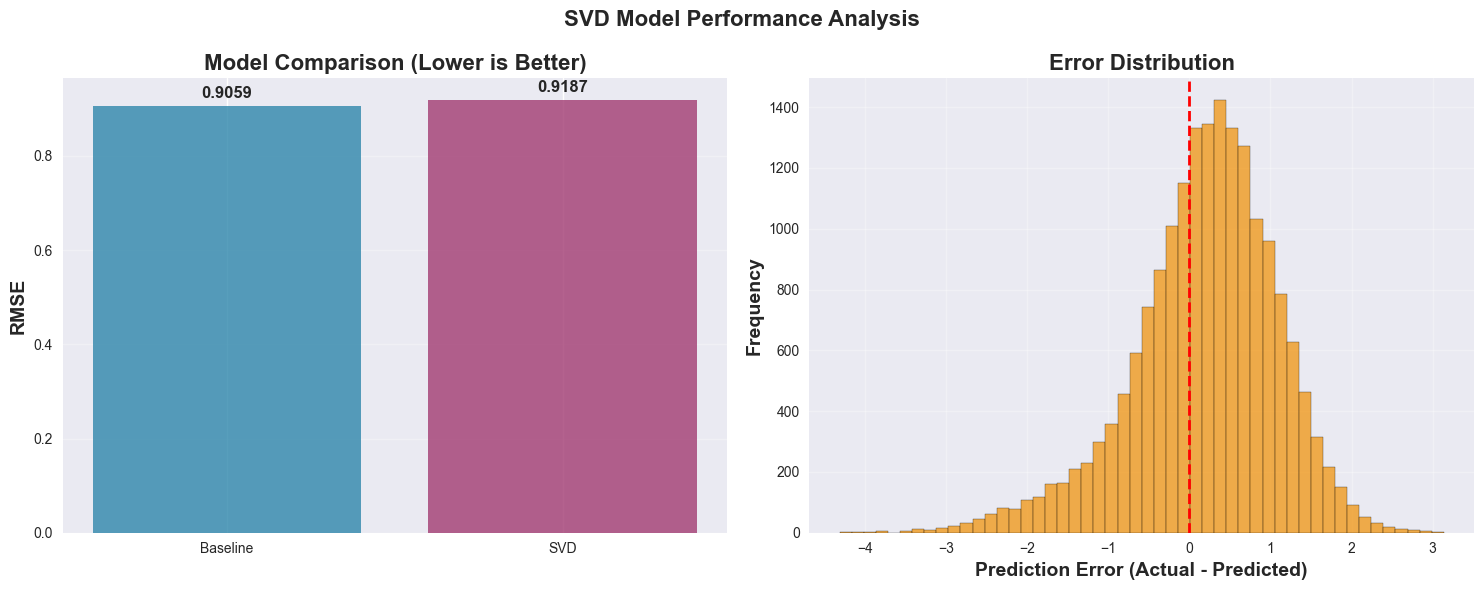

In [34]:
# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('SVD Model Performance Analysis', fontsize=16, fontweight='bold')

# 1. RMSE Comparison
models = ['Baseline', 'SVD']
rmse_values = [rmse_baseline, rmse_svd]

bars1 = axes[0].bar(models, rmse_values, color=['#2E86AB', '#A23B72'], alpha=0.8)
axes[0].set_ylabel('RMSE', fontweight='bold')
axes[0].set_title('Model Comparison (Lower is Better)', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for bar, value in zip(bars1, rmse_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. Error Distribution
errors = np.array(actuals_svd) - np.array(preds_svd)
axes[1].hist(errors, bins=50, color='#F18F01', edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Prediction Error (Actual - Predicted)', fontweight='bold')
axes[1].set_ylabel('Frequency', fontweight='bold')
axes[1].set_title('Error Distribution', fontweight='bold')
axes[1].grid(alpha=0.3)


plt.tight_layout()
plt.show()

### A. **Model Comparison Bar Chart**
*   **Metrics**: Compares the **SVD model** (RMSE: 0.9187) against the **Baseline model** (RMSE: 0.9059).
*   **Key Takeaway**: The SVD model's bar is slightly higher, confirming the quantitative result that it underperforms the baseline by **1.41%** in terms of RMSE.

### B. **Error Distribution Histogram**
*   **X-axis**: Prediction Error (`Actual - Predicted`). Values around 0 are perfect predictions. Negative errors are over-predictions; positive errors are under-predictions.
*   **Y-axis**: Frequency of each error.
*   **Distribution Shape**:
    *   The distribution is roughly centered near **0**, indicating no major systematic bias.
    *   It is approximately symmetric and bell-shaped, suggesting errors are normally distributed, which is a good sign for model diagnostics.
    *   The spread (width) of the distribution correlates directly with the model's RMSE and MAE.

**Conclusion from Figure 2**: The visualizations confirm the SVD model, while well-behaved in its error distribution, does not outperform the simpler baseline model on this dataset and task.

## Generate Sample Recommendations with SVD

In [35]:
print("\n" + "="*50)
print("SAMPLE RECOMMENDATIONS WITH SVD")
print("="*50)

# Sample user for demonstration
sample_user = df_test['userId'].iloc[0]
print(f"\n Recommendations for User {sample_user}:")

# Get user's rated movies
user_history = df_train[df_train['userId'] == sample_user]
if len(user_history) > 0:
    print(f"\nUser's rating profile:")
    print(f"  Number of movies rated: {len(user_history)}")
    print(f"  Average rating: {user_history['rating'].mean():.2f}")
    
    print(f"\nTop 3 movies they loved:")
    top_loved = user_history.nlargest(3, 'rating')
    for _, row in top_loved.iterrows():
        movie_title = df_movies[df_movies['movieId'] == row['movieId']]['title'].iloc[0]
        print(f"   {movie_title}: {row['rating']} stars")

# Get SVD recommendations
print(f"\n SVD Recommendations:")
svd_recommendations = final_svd_model.recommend(sample_user, k=5)

for i, (movie_id, pred_rating) in enumerate(svd_recommendations, 1):
    movie_title = df_movies[df_movies['movieId'] == movie_id]['title'].iloc[0]
    genres = df_movies[df_movies['movieId'] == movie_id]['genres'].iloc[0]
    print(f"  {i}. {movie_title}")
    print(f"     Predicted Rating: {pred_rating:.2f} | Genres: {genres}")

# Compare with baseline recommendations
print(f"\n Comparison with Baseline Recommendations:")
baseline_recs = baseline_model.recommend(sample_user, k=5)

print(f"\n{'Rank':<6} {'SVD Recommendation':<40} {'Baseline Recommendation':<40}")
print("-"*90)
for i in range(5):
    svd_movie_id, svd_pred = svd_recommendations[i] if i < len(svd_recommendations) else (None, 0)
    base_movie_id, base_pred = baseline_recs[i] if i < len(baseline_recs) else (None, 0)
    
    svd_title = df_movies[df_movies['movieId'] == svd_movie_id]['title'].iloc[0] if svd_movie_id else "N/A"
    base_title = df_movies[df_movies['movieId'] == base_movie_id]['title'].iloc[0] if base_movie_id else "N/A"
    
    print(f"{i+1:<6} {svd_title[:38]:<40} {base_title[:38]:<40}")


SAMPLE RECOMMENDATIONS WITH SVD

 Recommendations for User 429:

User's rating profile:
  Number of movies rated: 44
  Average rating: 4.07

Top 3 movies they loved:
   Crimson Tide (1995): 5.0 stars
   Apollo 13 (1995): 5.0 stars
   Aladdin (1992): 5.0 stars

 SVD Recommendations:
  1. Schindler's List (1993)
     Predicted Rating: 4.45 | Genres: Drama|War
  2. Shawshank Redemption, The (1994)
     Predicted Rating: 4.40 | Genres: Crime|Drama
  3. Blade Runner 2049 (2017)
     Predicted Rating: 4.36 | Genres: Sci-Fi
  4. Failure to Launch (2006)
     Predicted Rating: 4.33 | Genres: Comedy|Romance
  5. Casablanca (1942)
     Predicted Rating: 4.32 | Genres: Drama|Romance

 Comparison with Baseline Recommendations:

Rank   SVD Recommendation                       Baseline Recommendation                 
------------------------------------------------------------------------------------------
1      Schindler's List (1993)                  Paths of Glory (1957)                   
2   